In [18]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
from datasets import Dataset
import json
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [17]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
dataset_path = "./Capstone"
print("Path to dataset files:", dataset_path)

Path to dataset files: ./Capstone


In [20]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

In [21]:
data = []
with open(f"{dataset_path}/yelp_academic_dataset_review.json", "r", encoding="utf-8") as f:
    k=0
    for line in f:
        print(line)
        if(k==1):
            break
        k+=1

{"review_id":"KU_O5udG6zpxOg-VcAEodg","user_id":"mh_-eMZ6K5RLWhZyISBhwA","business_id":"XQfwVwDr-v0ZS3_CbbE5Xw","stars":3.0,"useful":0,"funny":0,"cool":0,"text":"If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.","date":"2018-07-07 22:09:11"}

{"review_id":"BiTunyQ73aT9WBnpR9DZGw","user_id":"OyoGAe7OKpv6SyGZT5g77Q","business_id":"7ATYjTIgM3jUlt4UM3IypQ","stars":5.0,"useful":1,"funny":0,"cool":1,"text":"I've taken a lot of spin classes over the years, and nothing compares to the classes at Body Cycle. From the nice, clean space a

In [22]:
data = []
k=0
with open(f"{dataset_path}/yelp_academic_dataset_review.json", "r", encoding="utf-8") as f:
    for line in f:
        if k==20:
            break
        try:
            entry = json.loads(line.strip())
            if all(key in entry for key in ["review_id", "user_id", "business_id", "stars", "text", "date"]):
                data.append({"review_id": entry["review_id"], "user_id": entry["user_id"], "business_id": entry["business_id"], "stars": entry["stars"], "text": entry["text"], "date": entry["date"]})
        except json.JSONDecodeError as e:
            print(f"Skipping invalid JSON line: {e}")
        k+=1
data[0]

{'review_id': 'KU_O5udG6zpxOg-VcAEodg',
 'user_id': 'mh_-eMZ6K5RLWhZyISBhwA',
 'business_id': 'XQfwVwDr-v0ZS3_CbbE5Xw',
 'stars': 3.0,
 'text': "If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.",
 'date': '2018-07-07 22:09:11'}

In [23]:
df = pd.DataFrame(data)
print("Loaded", len(df), "valid reviews.")

Loaded 20 valid reviews.


In [24]:
def preprocess_text(text):
    words = text.lower().split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

In [25]:
df["processed_text"] = df["text"].apply(preprocess_text)

In [26]:
dataset = Dataset.from_pandas(df)
print("Dataset columns after processing:", dataset.column_names)

Dataset columns after processing: ['review_id', 'user_id', 'business_id', 'stars', 'text', 'date', 'processed_text']


In [27]:
tokenizer.pad_token = tokenizer.eos_token
# Tokenization
def tokenize_function(examples):
    tokenized = tokenizer(examples["processed_text"], truncation=True, padding="max_length", max_length=512)
    tokenized["labels"] = tokenized["input_ids"][:]  # Copy input_ids to labels
    print(k)
    return tokenized

dataset = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

20


In [28]:
print("Dataset columns after processing:", dataset.column_names)


Dataset columns after processing: ['review_id', 'user_id', 'business_id', 'stars', 'text', 'date', 'processed_text', 'input_ids', 'attention_mask', 'labels']


In [29]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    save_total_limit=2,
    logging_dir="./logs",
    report_to="none"
)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [30]:
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
from datasets import DatasetDict

# Split the dataset into training (80%) and validation (20%)
dataset = dataset.train_test_split(test_size=0.2)

# Assign split datasets
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

# Trainer setup with proper dataset splits
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)


In [31]:
train_result = trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,5.785200,3.069405
2,2.330600,1.447000
3,1.402800,1.127721


In [32]:
model.save_pretrained("./fine_tuned_gpt2")
tokenizer.save_pretrained("./fine_tuned_gpt2")


('./fine_tuned_gpt2/tokenizer_config.json',
 './fine_tuned_gpt2/special_tokens_map.json',
 './fine_tuned_gpt2/vocab.json',
 './fine_tuned_gpt2/merges.txt',
 './fine_tuned_gpt2/added_tokens.json')

In [33]:
metrics = train_result.metrics
with open("training_metrics.json", "w") as f:
    json.dump(metrics, f)


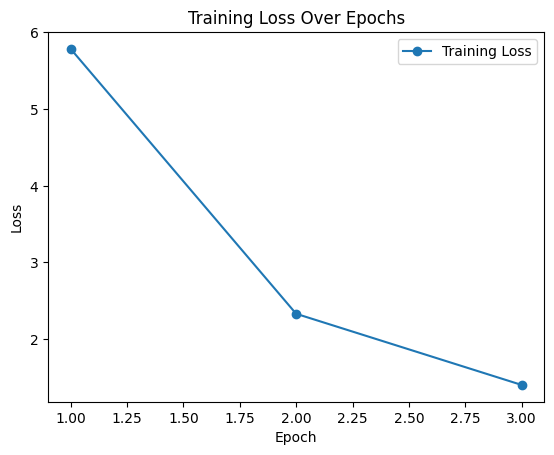

In [34]:
def plot_loss():
    train_loss = trainer.state.log_history
    losses = [entry["loss"] for entry in train_loss if "loss" in entry]
    epochs = list(range(1, len(losses) + 1))
    plt.plot(epochs, losses, marker='o', label='Training Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.show()

plot_loss()


In [35]:
def generate_response(prompt, max_length=50):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    outputs = model.generate(**inputs, max_length=max_length, num_return_sequences=1, temperature=0.7)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Feedback generation using rating
def generate_feedback(review_text, rating):
    prompt = f"Generate feedback based on rating {rating}: {review_text}"
    return generate_response(prompt)

# Feedback response
def respond_to_feedback(feedback_text):
    prompt = f"Respond to this customer feedback: {feedback_text}"
    return generate_response(prompt)

# Review insights extraction
def extract_review_insights(review_text):
    prompt = f"Provide insights for this review: {review_text}"
    return generate_response(prompt)


In [36]:
print("Feedback Generation:\n\n", generate_feedback("The food was amazing, but the service was slow.", 4))
print("Feedback Response:\n\n", respond_to_feedback("The service was slow."))
print("Review Insights:\n\n", extract_review_insights("The ambiance was great but the food was overpriced."))

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Feedback Generation:

 Generate feedback based on rating 4: The food was amazing, but the service was slow. I would recommend this place to anyone who is looking for a great place to eat.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Feedback Response:

 Respond to this customer feedback: The service was slow. I was able to get a refund within a few hours.
Review Insights:

 Provide insights for this review: The ambiance was great but the food was overpriced. The service was very good and the staff was friendly. The food was good but the service was not good. The service was not good. The food


In [45]:
import evaluate

def compute_rouge(predictions, references):
    rouge = evaluate.load("rouge")
    results = rouge.compute(predictions=predictions, references=references)
    return results

# Compute Perplexity
def compute_perplexity(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss
    perplexity = torch.exp(loss)
    return perplexity.item()

# Compute Accuracy
def compute_accuracy(predictions, references):
    correct = sum([1 for pred, ref in zip(predictions, references) if pred.strip() == ref.strip()])
    return correct / len(predictions) if predictions else 0

In [46]:
preds = ["The ambiance was good, but food was too expensive."]
refs = ["The ambiance was great but the food was overpriced."]
rouge_scores = compute_rouge(preds, refs)
print("ROUGE Score:", rouge_scores)

# Example Perplexity computation
example_text = "The food was great but the service was slow."
perplexity_score = compute_perplexity(example_text)
print("Perplexity:", perplexity_score)

# Example Accuracy computation
accuracy_score = compute_accuracy(preds, refs)
print("Accuracy:", accuracy_score)

ROUGE Score: {'rouge1': 0.6666666666666666, 'rouge2': 0.375, 'rougeL': 0.6666666666666666, 'rougeLsum': 0.6666666666666666}
Perplexity: 19.483152389526367
Accuracy: 0.0


In [52]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
bleu_score = sentence_bleu(refs, preds)
print("BLEU Score:", bleu_score)

BLEU Score: 0
